In [2]:
import os
import pandas as pd
import numpy as np
import torch as th
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
import collections
import sys
from torch.utils.data import DataLoader

sys.path.insert(1, '../Scripts')
import cgnn_functions as cgnnFun
import distance_functions as dFun
import utilities_functions as uFun
import visualization_functions as vFun

In [2]:
#cw_dir = '/Users/omid/Documents/GitHub/Causality/cit/'
cw_dir = '/home/charrakho/cit/cit/'

cfg = uFun.load_json(os.path.join(cw_dir, 'Data/cfg.json'))

data_paths = [
    os.path.join(cw_dir, 'Data/datasets/dat_train.csv'), 
    os.path.join(cw_dir, 'Data/datasets/dat_val.csv'), 
    os.path.join(cw_dir, 'Data/datasets/dat_test.csv'),
    ]

data_paths_calib = [
    os.path.join(cw_dir, 'Data/datasets/dat_calib_high.csv'), 
    os.path.join(cw_dir, 'Data/datasets/dat_calib_noCorr.csv')
]

criteria_train = [
    dFun.MMD_cdt(bandwidth=[1]), 
    dFun.CorrD([1, 1], 3), 
    dFun.CndD(sample_weighting=True, sampling_rate=3, num_std_moments=4, weighting_exp=1)
]
criteria_train_wgs = []


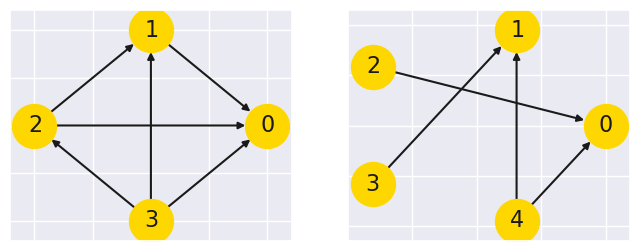

In [3]:
candidate_path = os.path.join(cw_dir, 'Data/candidates/saturated_cand.txt')
A1 = np.loadtxt(candidate_path).reshape(4,4)
candidate_path = os.path.join(cw_dir, 'Data/candidates/qcm_cands.txt')
A2 = np.loadtxt(candidate_path).reshape(5,5)
uFun.graph_plotter(A1, A2)

# Optimizing of nb_base_hu

Idea: increase nb_base_hu and store the CGNN performances for each number 

=> choose the number above which no significant performance is achievable 

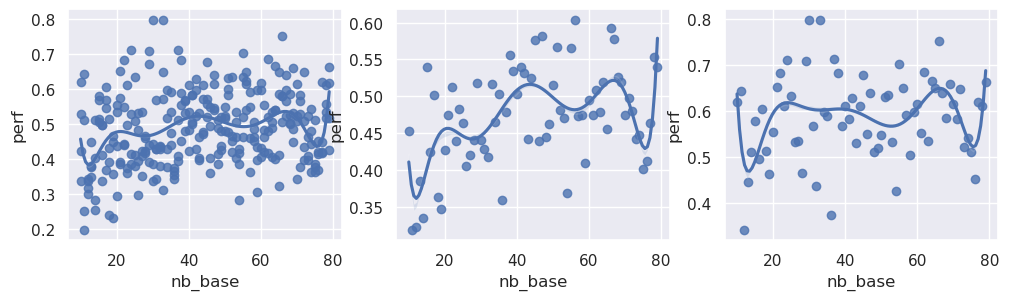

In [10]:
# run the 'hu_optimization' experiment and save the results firstly
# then analyze the results as follows

experiment = 'hu_optimization'

X = []
Y = []
for nb_base in list(range(10, 80)):
    eval_name='_{}'.format(nb_base)
    for index_run in range(4):
        path_perf = os.path.join(cw_dir, 'Results/{}/performance/c0_r{}{}.csv'.format(experiment, index_run, eval_name))
        df_perf = pd.read_csv(path_perf)
        perf_mean = df_perf.abs().mean().mean()
        X.append(nb_base)
        Y.append(perf_mean)

df_0 = pd.DataFrame()
df_0['nb_base'] = X
df_0['perf'] = Y
#df_0 = df_0[df_0["perf"]<4] # to remove outliers if needed
df_1 = uFun.reduce_df(df_0, 'mean') # to track the average perfmance of all runs for each nb_hu => main plot
df_2 = uFun.reduce_df(df_0, 'min') # to track the best run for each nb_hu 

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.regplot(x=df_0['nb_base'], y=1/df_0['perf'], order=10, ci=10, scatter=True, ax=axes[0])
sns.regplot(x=df_1['nb_base'], y=1/df_1['perf'], order=10, ci=10, scatter=True, ax=axes[1])
sns.regplot(x=df_2['nb_base'], y=1/df_2['perf'], order=10, ci=10, scatter=True, ax=axes[2])
plt.savefig('hu_optimization.png', dpi=300)
plt.show()
plt.close()

# we take 40 as the best number